# Stratified Split

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

name = 'parkers_brook'
data_dir = 'data'
site_dir = os.path.join(data_dir, name)
img_dir =  os.path.join(site_dir, 'images')

In [3]:
annotations_file = os.path.join(site_dir, 'images.csv')
df = pd.read_csv(annotations_file, dtype={'flow_cfs': np.float32})
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_convert(tz='US/Eastern')
df['week'] = df['timestamp'].dt.isocalendar().week
df['year'] = df['timestamp'].dt.isocalendar().year
df.sort_values(by='timestamp', inplace=True, ignore_index=True)

print(f'rows: {len(df)}')
df.head()

rows: 5797


,filename,timestamp,flow_cfs,week,year
0,20180613_1230_ParkersBrook.JPG,2018-06-13 08:30:00-04:00,3.35,24,2018
1,20180613_1330_ParkersBrook.JPG,2018-06-13 09:30:00-04:00,3.97,24,2018
2,20180613_1430_ParkersBrook.JPG,2018-06-13 10:30:00-04:00,3.76,24,2018
3,20180613_1530_ParkersBrook.JPG,2018-06-13 11:30:00-04:00,3.76,24,2018
4,20180613_1630_ParkersBrook.JPG,2018-06-13 12:30:00-04:00,3.76,24,2018


In [5]:
weekly_flow_means = df[['flow_cfs', 'year', 'week']].groupby(['year', 'week']).mean().rename(columns={'flow_cfs': 'mean_flow_cfs'})
weekly_flow_means.head()

mean_flow_cfs
year week               
2018 24         3.848125
     25         3.683163
     26        15.810147
     27        11.194694
     28         9.438878

In [6]:
weekly_flow_quantiles = np.quantile(weekly_flow_means['mean_flow_cfs'].values, [.25, .75], axis=0)
weekly_flow_quantiles

array([ 6.99216723, 16.00491786])

In [7]:
def classify(low_value, high_value, value):
    if value <= low_value:
        return 'low'
    elif value >= high_value:
        return 'high'
    else:
        return 'med'

weekly_flow_means['flow_class'] = weekly_flow_means['mean_flow_cfs'].map(lambda x: classify(weekly_flow_quantiles[0], weekly_flow_quantiles[1], x))
weekly_flow_means['week_index'] = range(len(weekly_flow_means.index))

weekly_flow_means.head()

mean_flow_cfs flow_class  week_index
year week                                      
2018 24         3.848125        low           0
     25         3.683163        low           1
     26        15.810147        med           2
     27        11.194694        med           3
     28         9.438878        med           4

In [8]:
df_week = df.set_index(['year', 'week']).join(weekly_flow_means, on=['year', 'week']).reset_index()
df_week

,year,week,filename,timestamp,flow_cfs,mean_flow_cfs,flow_class,week_index
0,2018,24,20180613_1230_ParkersBrook.JPG,2018-06-13 08:30:00-04:00,3.35,3.848125,low,0
1,2018,24,20180613_1330_ParkersBrook.JPG,2018-06-13 09:30:00-04:00,3.97,3.848125,low,0
2,2018,24,20180613_1430_ParkersBrook.JPG,2018-06-13 10:30:00-04:00,3.76,3.848125,low,0
3,2018,24,20180613_1530_ParkersBrook.JPG,2018-06-13 11:30:00-04:00,3.76,3.848125,low,0
4,2018,24,20180613_1630_ParkersBrook.JPG,2018-06-13 12:30:00-04:00,3.76,3.848125,low,0
...,...,...,...,...,...,...,...,...
5792,2019,43,20191023_1400_ParkersBrook.jpg,2019-10-23 10:00:00-04:00,6.57,5.194828,low,71
5793,2019,43,20191023_1500_ParkersBrook.jpg,2019-10-23 11:00:00-04:00,6.57,5.194828,low,71
5794,2019,43,20191023_1600_ParkersBrook.jpg,2019-10-23 12:00:00-04:00,6.57,5.194828,low,71
5795,2019,43,20191024_0800_ParkersBrook.jpg,2019-10-24 04:00:00-04:00,5.17,5.194828,low,71


In [14]:
min_hour = 7
max_hour = 18
df_week_filter = df_week[df_week['timestamp'].dt.hour.between(min_hour, max_hour)]
        
min_month = 1
max_month = 12
df_week_filter = df_week_filter[df_week_filter['timestamp'].dt.month.between(min_month, max_month)]

len(df_week_filter) / len(df_week)

0.6284284974987062

In [11]:
# weeks = avery.table[['flow_class', 'year', 'week', 'week_index']].drop_duplicates()
weeks = weekly_flow_means.reset_index()
seed = 1
test_size = 0.2

X = weeks['week_index']
y = weeks['flow_class']

sss = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=seed)
idx_train, idx_test = list(sss_test.split(X, y))[0]

weeks['split'] = weeks['week_index'].map(lambda x: 'train' if x in idx_train else 'test')
weeks.head(10)

,year,week,mean_flow_cfs,flow_class,week_index,split
0,2018,24,3.848125,low,0,train
1,2018,25,3.683163,low,1,train
2,2018,26,15.810147,med,2,test
3,2018,27,11.194694,med,3,test
4,2018,28,9.438878,med,4,train
5,2018,29,13.910516,med,5,train
6,2018,30,17.645834,high,6,train
7,2018,31,14.196154,med,7,train
8,2018,32,17.505934,high,8,train
9,2018,33,22.329214,high,9,train


In [12]:
weeks.groupby(['flow_class']).size() / len(weeks.index) * 100

flow_class
high    25.0
low     25.0
med     50.0
dtype: float64

In [13]:
weeks.groupby(['split', 'flow_class']).size()

split  flow_class
test   high           2
       low            2
       med            4
train  high          16
       low           16
       med           32
dtype: int64

In [15]:
df_train = df_week_filter[df_week_filter['week_index'].isin(train_idx)]
df_test = df_week_filter[df_week_filter['week_index'].isin(test_idx)]
len(df_train), len(df_test)

(2972, 398)

In [16]:
df_train.groupby('flow_class').size()

flow_class
high     909
low      499
med     1564
dtype: int64

In [17]:
df_test.groupby('flow_class').size()

flow_class
high     96
low      98
med     204
dtype: int64

In [21]:
df_week_filter['split'] = df_week_filter['week_index'].map(lambda x: 'train' if x in idx_train else 'test')

In [23]:
df_week_filter.groupby(['split', 'flow_class']).size()

split  flow_class
test   high            96
       low             98
       med            204
train  high           813
       low            735
       med           1697
dtype: int64

In [24]:
df_week_filter

,year,week,filename,timestamp,flow_cfs,mean_flow_cfs,flow_class,week_index,split
0,2018,24,20180613_1230_ParkersBrook.JPG,2018-06-13 08:30:00-04:00,3.35,3.848125,low,0,train
1,2018,24,20180613_1330_ParkersBrook.JPG,2018-06-13 09:30:00-04:00,3.97,3.848125,low,0,train
2,2018,24,20180613_1430_ParkersBrook.JPG,2018-06-13 10:30:00-04:00,3.76,3.848125,low,0,train
3,2018,24,20180613_1530_ParkersBrook.JPG,2018-06-13 11:30:00-04:00,3.76,3.848125,low,0,train
4,2018,24,20180613_1630_ParkersBrook.JPG,2018-06-13 12:30:00-04:00,3.76,3.848125,low,0,train
...,...,...,...,...,...,...,...,...,...
5790,2019,43,20191023_1200_ParkersBrook.jpg,2019-10-23 08:00:00-04:00,7.19,5.194828,low,71,train
5791,2019,43,20191023_1300_ParkersBrook.jpg,2019-10-23 09:00:00-04:00,7.19,5.194828,low,71,train
5792,2019,43,20191023_1400_ParkersBrook.jpg,2019-10-23 10:00:00-04:00,6.57,5.194828,low,71,train
5793,2019,43,20191023_1500_ParkersBrook.jpg,2019-10-23 11:00:00-04:00,6.57,5.194828,low,71,train


<AxesSubplot:xlabel='timestamp', ylabel='flow_cfs'>

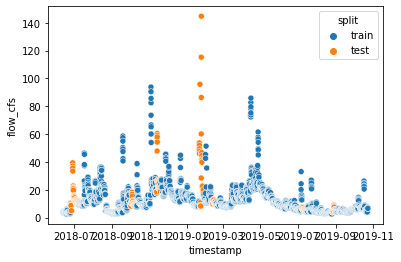

In [31]:
sns.scatterplot(data=df_week_filter, x="timestamp", y="flow_cfs", hue="split")

In [33]:
def classify3(low_value, high_value, value):
    if value <= low_value:
        return 'low'
    elif value >= high_value:
        return 'high'
    else:
        return 'med'

def split_weekly_flow(x, test_size=0.2, seed=1):
    df = x.copy()
    df['week'] = df['timestamp'].dt.isocalendar().week
    df['year'] = df['timestamp'].dt.isocalendar().year
    df.sort_values(by='timestamp', inplace=True, ignore_index=True)
    
    weekly_flow_means = df[['flow_cfs', 'year', 'week']].groupby(['year', 'week']).mean().rename(columns={'flow_cfs': 'mean_flow_cfs'})
    weekly_flow_quantiles = np.quantile(weekly_flow_means['mean_flow_cfs'].values, [.25, .75], axis=0)
    
    weekly_flow_means['flow_class'] = weekly_flow_means['mean_flow_cfs'].map(lambda x: classify3(weekly_flow_quantiles[0], weekly_flow_quantiles[1], x))
    weekly_flow_means['week_index'] = range(len(weekly_flow_means.index))

    df = df.set_index(['year', 'week']).join(weekly_flow_means, on=['year', 'week']).reset_index()
    
    weeks = weekly_flow_means.reset_index()

    X = weeks['week_index']
    y = weeks['flow_class']

    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    week_idx_train, week_idx_test = list(sss_test.split(X, y))[0]

    weeks['split'] = weeks['week_index'].map(lambda x: 'train' if x in week_idx_train else 'test')
    df['split'] = df['week_index'].map(lambda x: 'train' if x in week_idx_train else 'test')
    
    return df[df['split'] == 'train'], df[df['split'] == 'test']

In [49]:
df = pd.read_csv(annotations_file, dtype={'flow_cfs': np.float32})
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_convert(tz='US/Eastern')

# filter by hour
min_hour = 7
max_hour = 18
df = df[df['timestamp'].dt.hour.between(min_hour, max_hour)]
        
min_month = 5
max_month = 10
df = df[df['timestamp'].dt.month.between(min_month, max_month)]

train_df, test_df = split_week_flow(df)

<AxesSubplot:xlabel='timestamp', ylabel='flow_cfs'>

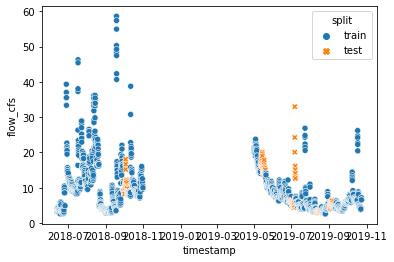

In [57]:
df_split = pd.concat([train_df, test_df])
df_split.sort_values(by='timestamp', inplace=True, ignore_index=True)
sns.scatterplot(data=df_split, x="timestamp", y="flow_cfs", hue="split", style="split")

In [58]:
df_split.groupby(['split', 'flow_class']).size()

split  flow_class
test   high            56
       low             42
       med            154
train  high           621
       low            527
       med           1008
dtype: int64